# Self-Driving Car Engineer Nanodegree


## Project 1: **Finding Lane Lines on the Road** 
***
This project focuses on finding lane lines in a video stream using the lessons learned in Udacity Self Driving Nano-Degree Program. 

Major steps to develop the lane line detection algorithm include:
- Color selection and filtering, 
- Grayscaling the image, 
- Gaussian smoothing to reduce the noise in images, 
- Canny Edge Detection, 
- Haugh Transform line segment detection,
- Defining region of interest in the image,
- Classifying detected line segments in the region of interest into left and right categories,
- Removing outliers from left and right line segments
- Calculating a median slope and intercept for left and right lane lines using detected line segments
- Creating left and right lane lines using the calculated slope and intercept for each frame
- Smoothing and averaging consecutive detected lines to reduce noise and handle challenging frames
- Illustrating the result on frames and video files

## Import Packages
Packages from matplotlib, numpy, cv2, math and os libraries are used in this program:

In [5]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Functions and Global Variables
Below are some functions that are used in this program:
    

In [6]:
# Defining functions used in this program
def initialize():
    """ Initializes window size of the buffer and slope and intercept arrays """
    window_size = 8
    global prev_slope_array_left
    global prev_intercept_array_left
    global prev_slope_array_right
    global prev_intercept_array_right
    prev_slope_array_left = np.zeros(window_size)
    prev_intercept_array_left = np.zeros(window_size)
    prev_slope_array_right = np.zeros(window_size)
    prev_intercept_array_right = np.zeros(window_size) 

def classify_lines(lines):
    """ Takes an array of hough lines and separates them by slopes. 
        Positive slopes will be right lane lines and negative slopes will be left lanes. """
    right = []
    left = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1) / (x2 - x1)
            if (m > 0): 
                right.append(line)
            if (m < 0):
                left.append(line)
    return right, left

def remove_line_noise(lines, slope, tolerance):
    """ Removes outliers from the input lines based on the specified slope and tolerance """
    similar = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2 - y1) / (x2 - x1)
            if abs(m-slope)<tolerance:
                similar.append(line)
    return similar

def average_line_slope_intercept(lines):
    """ Calculates average slope and intercept of the input lines """
    cnt = 0
    slope = 0
    intercept = 0
    xa = []
    ya = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            xa.append(x1)
            xa.append(x2)
            ya.append(y1)
            ya.append(y2)
            slope, intercept = np.polyfit(xa, ya, 1)
    return slope, intercept     

def buffer(array,new_element):
    """ Keeps a First-In-First-Out buffer of elements in an array """
    array_list=list(array)
    for k in range(np.size(array)-1):
        array_list[k]=array_list[k+1];
    array_list[(np.size(array)-1)] = new_element;
    return tuple(array_list)   

def bgr2rgb(bgr_img):
    """ Converts BGR to RGB image """
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    return rgb_img

def lane_line_illustrate(image):
    """ Determine what type of processed output to illustrate on the images/videos 
        See the outputs of the lane_line_detedct class below for options """
    output_image = lane_line_detect(image).detected_lines
    return output_image

# Defining global variables
global prev_slope_array_left
global prev_intercept_array_left
global prev_slope_array_right
global prev_intercept_array_right

## Lane Finding Pipeline
This pipeline processes the input image/frame and detects lane lines.

In [7]:
class lane_line_detect:
    def __init__(self, image):
        global prev_slope_array_left
        global prev_intercept_array_left
        global prev_slope_array_right
        global prev_intercept_array_right

        # Grayscale the image
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Define a kernel size and apply Gaussian smoothing
        kernel_size = 5
        blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

        # Define parameters for Canny and apply
        low_threshold = 50
        high_threshold = 100
        edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

        # Create a masked edges image using cv2.fillPoly()
        mask = np.zeros_like(edges)   
        ignore_mask_color = 255 
        
        # Define a four sided polygon to mask  , (0,0)=top_left, X: horizontal to right, Y vertical to bottom
        imshape = image.shape  
        X = imshape[1]
        Y = imshape[0]
        region_bl = (0,Y*0.90)
        region_tl = (0.35*X, 0.65*Y)
        region_br = (0.65*X, 0.65*Y)
        region_tr = (X,Y*0.90)
        vertices = np.array([[region_bl,region_tl,region_br,region_tr]], dtype=np.int32)
        
        # Apply the region of interest to the mask
        cv2.fillPoly(mask, vertices, ignore_mask_color)
        masked_edges = cv2.bitwise_and(edges, mask)
        
        # Define the Hough transform parameters
        rho = 0.99 # distance resolution in pixels of the Hough grid
        theta = np.pi/1800 # angular resolution in radians of the Hough grid
        threshold = 30    # minimum number of votes (intersections in Hough grid cell)
        min_line_length = 25 #minimum number of pixels making up a line 
        max_line_gap = 50   # maximum gap in pixels between connectable line segments
        line_image = np.copy(image)*0 # creating a blank to draw lines on

        # Run Hough on edge detected image
        # Output "lines" is an array containing endpoints of detected line segments
        lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                    min_line_length, max_line_gap)
        
        # Use previous lines if there is no line detected 
        global prev_lines
        if not lines.any():
            print(lines)
            lines = prev_lines
        prev_lines = lines
        
        # Iterate over the output "lines" and draw lines on a blank image
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

        # Create a "color" binary image to combine with line image
        color_edges = np.dstack((edges, edges, edges)) 

        # Draw the lines on the edge image
        lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
        
        # Draw the lines on the original image
        segments_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
  
        # Classify lines on the image to left and right lines
        right_lines, left_lines = classify_lines(lines)
        
        # Creating images with right and left lines for illustration purposes
        left_line_image = np.copy(image)
        for line in left_lines:
            for x1,y1,x2,y2 in line:
                cv2.line(left_line_image,(x1,y1),(x2,y2),(255,0,0),10)
        right_line_image = np.copy(image)
        for line in right_lines:
            for x1,y1,x2,y2 in line:
                cv2.line(right_line_image,(x1,y1),(x2,y2),(255,0,0),10)
        
        # Remove outlier lines from the right and left lines using median slope and tolerance
        right_filtered = remove_line_noise(right_lines, 0.7, 0.2)
        left_filtered = remove_line_noise(left_lines, -0.7, 0.2)
        
        # Calculate the slope for left and right average line
        right_slope, right_intercept = average_line_slope_intercept(right_filtered)
        left_slope, left_intercept = average_line_slope_intercept(left_filtered)
        
        
        ###  Initialize the slope/intercept buffer with slope/intercept from first frame
        if np.mean(prev_slope_array_left) == 0:
            prev_slope_array_left = left_slope * np.ones(np.size(prev_slope_array_left))
            prev_intercept_array_left = left_intercept * np.ones(np.size(prev_intercept_array_left))
            
        if np.mean(prev_slope_array_right) == 0:
            prev_slope_array_right = right_slope * np.ones(np.size(prev_slope_array_right))
            prev_intercept_array_right = right_intercept * np.ones(np.size(prev_intercept_array_right))

            
        # Update the slope/intercept buffer using the current slope/interface
        if left_slope != 0:
            prev_slope_array_left = buffer(prev_slope_array_left, left_slope)
            prev_intercept_array_left = buffer(prev_intercept_array_left, left_intercept)
            
        if right_slope != 0:
            prev_slope_array_right = buffer(prev_slope_array_right, right_slope)
            prev_intercept_array_right = buffer(prev_intercept_array_right, right_intercept)

      
        # Calculate smoothed slope/intercept using the buffered values 
        left_slope = np.median(prev_slope_array_left)
        left_intercept = np.median(prev_intercept_array_left)    
        
        right_slope = np.median(prev_slope_array_right)
        right_intercept = np.median(prev_intercept_array_right)  
        
        # Draw average lines on the image, using top/bottom-left/right points derived from average slope/intercept
        lane_display_length = 1.6
        detected_line_img = np.copy((image)*0)
        Ybl = detected_line_img.shape[0]
        Xbl = (Ybl - left_intercept)/left_slope
        Ytl = detected_line_img.shape[0] / lane_display_length
        Xtl = (Ytl - left_intercept)/left_slope
        Ybr = detected_line_img.shape[0]
        Xbr = (Ybr - right_intercept)/right_slope
        Ytr = detected_line_img.shape[0] / lane_display_length
        Xtr = (Ytr - right_intercept)/right_slope        
        cv2.line(detected_line_img, (int(Xbl),int(Ybl)), (int(Xtl),int(Ytl)),(250,0,250),15)
        cv2.line(detected_line_img, (int(Xbr),int(Ybr)), (int(Xtr),int(Ytr)),(250,0,250),15)    
        detected_lines =  cv2.addWeighted(detected_line_img, 0.8, image, 1, 0)
               
        # Output processed images
        self.gray = gray
        self.blur_gray = blur_gray
        self.edges = edges
        self.masked_edges = masked_edges
        self.line_image = line_image
        self.lines_edges = lines_edges
        self.segments_image = segments_image 
        self.left_line_segments = left_line_image
        self.right_line_segments = right_line_image
        self.detected_lines = detected_lines    

## Test on Images

The pipeline is first tested on the images in the directory "test_images". 

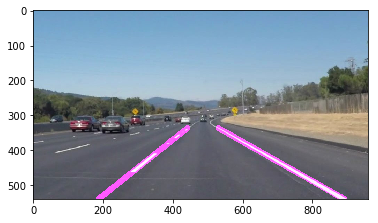

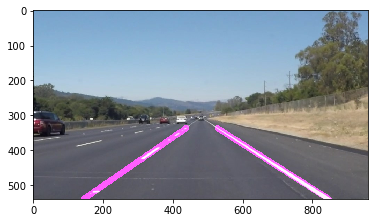

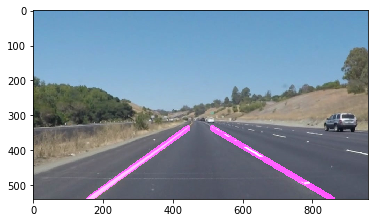

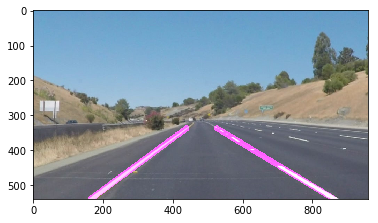

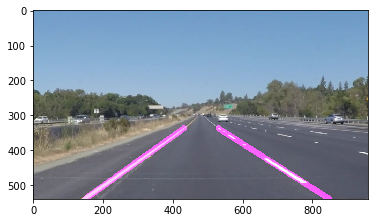

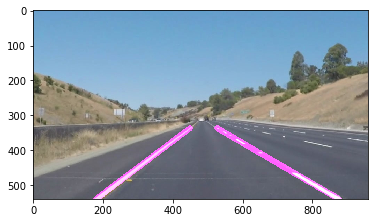

In [8]:
# Load Image Files
files = os.listdir("test_images/")

# Detect Lane Lines and save image files
for file in files:
    initialize()
    if file[0:len("output")] != "output":
        active_image = mpimg.imread("test_images/"+file)         
        cv2.imwrite("test_images/output_gray_"+file, (lane_line_detect(active_image).gray))
        cv2.imwrite("test_images/output_blur_gray_"+file, lane_line_detect(active_image).blur_gray)
        cv2.imwrite("test_images/output_edges_"+file, lane_line_detect(active_image).edges)
        cv2.imwrite("test_images/output_masked_edges_"+file, lane_line_detect(active_image).masked_edges)
        cv2.imwrite("test_images/output_line_image_"+file, bgr2rgb(lane_line_detect(active_image).line_image))
        cv2.imwrite("test_images/output_lines_edges_"+file, bgr2rgb(lane_line_detect(active_image).lines_edges))
        cv2.imwrite("test_images/output_detected_segments_"+file, bgr2rgb(lane_line_detect(active_image).segments_image))
        cv2.imwrite("test_images/output_right_segments_"+file, bgr2rgb(lane_line_detect(active_image).right_line_segments))
        cv2.imwrite("test_images/output_left_segments_"+file, bgr2rgb(lane_line_detect(active_image).left_line_segments))
        cv2.imwrite("test_images/output_detected_lines_"+file, bgr2rgb(lane_line_detect(active_image).detected_lines))
        # Display processed images
        plt.figure()  
        plt.imshow(lane_line_illustrate(active_image))


## Test on Videos

The pipeline is now tested on two video files:
- `solidWhiteRight.mp4` with white lane markings
- `solidYellowLeft.mp4` with yellow lane markings

### Let's try the one with the solid white lane on the right first ...

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
initialize()
white_clip = clip1.fl_image(lane_line_illustrate) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:11<00:00, 21.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 11.8 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))


### Now for the one with the solid yellow lane on the left. This one's more tricky!

In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
initialize()
yellow_clip = clip2.fl_image(lane_line_illustrate)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:39<00:00, 18.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 40.1 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

The pipeline is now tested on an a more interesting video feed! Road surface changes, lighting condition and shades makes lane detection more challenging for this case...

#### Let's see!

In [14]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
initialize()
challenge_clip = clip2.fl_image(lane_line_illustrate)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:29<00:00,  8.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 30.8 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))